In [51]:
# This program uses an artificial recurrent neural network called long short term memory (LSTM) to predict the closing 
# of a corporation (I will be using AAPL Inc.) using the past 60 day stock price

NN

In [52]:
# import the libraries needed
import math
import datetime
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yfin
plt.style.use("fivethirtyeight")

In [53]:
#Get the Stock Quote
yfin.pdr_override()

df = pdr.get_data_yahoo("AAPL", start="2012-01-01", end = "2022-09-20")


[*********************100%%**********************]  1 of 1 completed


In [54]:
# Get the number of rows and columns in the dataset
df.shape

(2696, 6)

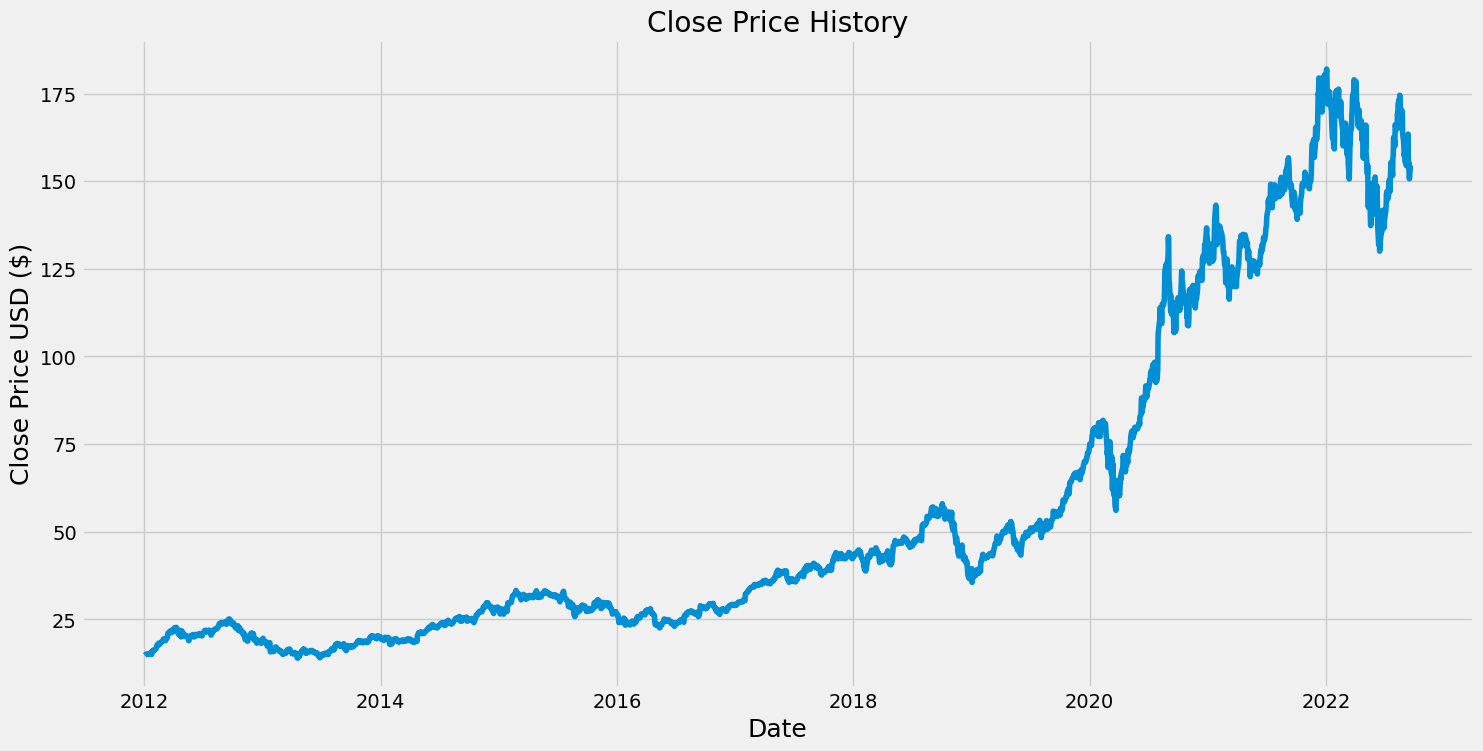

In [55]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD ($)", fontsize = 18)
plt.show()

In [56]:
# Create a new datafram with only close column
data = df.filter(["Close"])
# covert dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8)
print(training_data_len)

2157


In [57]:
#Scale the data
# applying preprocessing
scaler = MinMaxScaler(feature_range=(0,1)) # scales the data with min 0 max 1, (i.e minimum value in dataset becomes 0, max becomes 1 rest are scaled according)
scaled_data = scaler.fit_transform(dataset) 
scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.82363704],
       [0.81370027],
       [0.83619189]])

In [58]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
# split data into x_train and y_train
x_train = []
y_train = []
for i in range(60, len(train_data)):
    # per pass through, x_train will take first 60 values, and y will take 61st (i.e will use 60 values for predicting target 61st value)
    x_train.append(train_data[i-60:i, 0]) 
    y_train.append(train_data[i,0])

In [59]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [60]:
#Reshape the data, LSTM model expects 3 dim
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [61]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1],1)    ))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [62]:
model.compile(optimizer="adam", loss = "mean_squared_error")

In [63]:
#Train the model
model.fit(x_train,y_train, batch_size=1, epochs=1)

2097/2097 [==============================] - 29s 13ms/step - loss: 4.3892e-04


In [64]:
#Create the testing data set
# Create a new array containing scaled values from 1543 to 2003
test_data = scaled_data[training_data_len-60: , :]
#Create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [65]:
# convert data to numpy array
x_test = np.array(x_test)


In [66]:
#reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [67]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # reverse scale the predictions


17/17 [==============================] - 1s 9ms/step


In [68]:
#Get the root MSE 
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.657970718638574

C:\Users\Karanpal Sekhon\AppData\Local\Temp\ipykernel_23268\3611443382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


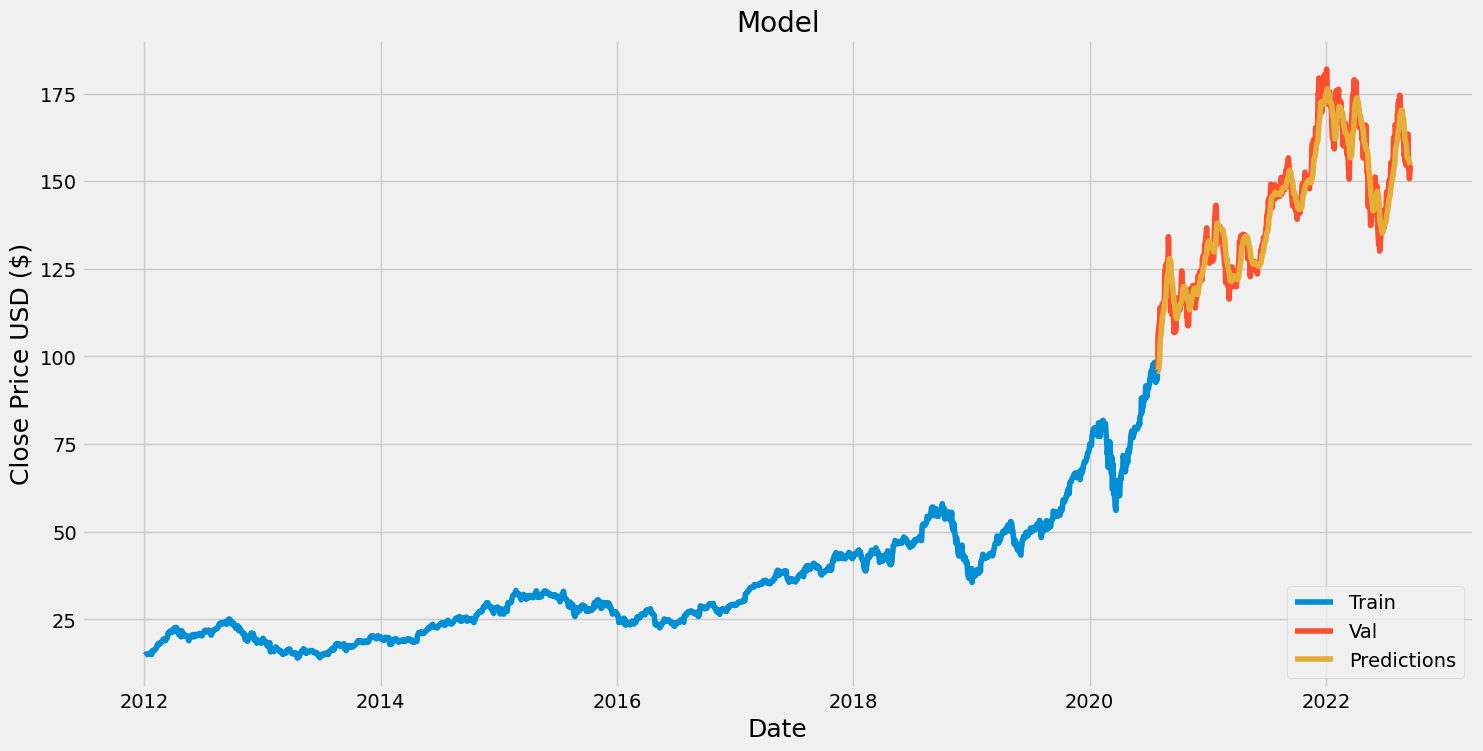

In [69]:
# plt the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD ($)", fontsize = 18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc = "lower right")
plt.show()